# In-class exercise: Comparison of SAR Wavelength and Polarization

In this notebook, we will aim to see how C-band (4–8 GHz, wavelengths of approximately 3.75–7.5 cm) and L-band (1–2 GHz, wavelengths of approximately 15–30 cm) radio frequencies differ for different land covers and times of the year. In addition, we'll look at co-polarized backscattering:

+ Sentinel-1: VV
+ ALOS-2: HH

And cross-polarized backscattering:

+ Sentinel-1: VH
+ ALOS-2: HV

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import hvplot.xarray #noqa
import holoviews as hv

### Data Loading

This is dataset that we created in the previous notebooks of exercise 4.

In [2]:
fused_ds = xr.open_dataset("fused_ds.zarr", engine="zarr", decode_coords="all",
                           chunks={})
fused_ds

<xarray.Dataset> Size: 460MB
Dimensions:      (time: 5, y: 1528, x: 2508, sensor: 4)
Coordinates:
    crs          int64 8B ...
  * sensor       (sensor) object 32B 's1_VV' 's1_VH' 'alos_HV' 'alos_HH'
    spatial_ref  int64 8B ...
  * time         (time) datetime64[ns] 40B 2022-06-30 2022-07-31 ... 2022-10-31
  * x            (x) float64 20kB 4.769e+06 4.769e+06 ... 4.794e+06 4.794e+06
  * y            (y) float64 12kB 1.397e+06 1.397e+06 ... 1.382e+06 1.382e+06
Data variables:
    LAI          (time, y, x) float64 153MB dask.array<chunksize=(1, 191, 627), meta=np.ndarray>
    gam0         (time, sensor, y, x) float32 307MB dask.array<chunksize=(2, 1, 382, 627), meta=np.ndarray>

The data we loaded contains the Leaf Area Index (LAI), which gives an idea of the green elements per unit of the horizontal ground surface. It is used as an estimate of foliage cover of forest canopies. So high LAI is interpreted as forested area whereas low values account for low-biomass vegetation. THE LAI product used in the exercise has a range of 0 to 7. Let's have a look at the mean and standard deviation of LAI over all timeslices. This can be easily achieved by using the `mean` and `std` methods of the `xarray` object and supplying a dimension over which to perform this aggregating operation. We use the dimension "time" in this case, thereby flattening the cube to a 2-D array.

/home/nicola/Documents/work/teaching/notebooks/microwave-remote-sensing/.conda_envs/mrs-env/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


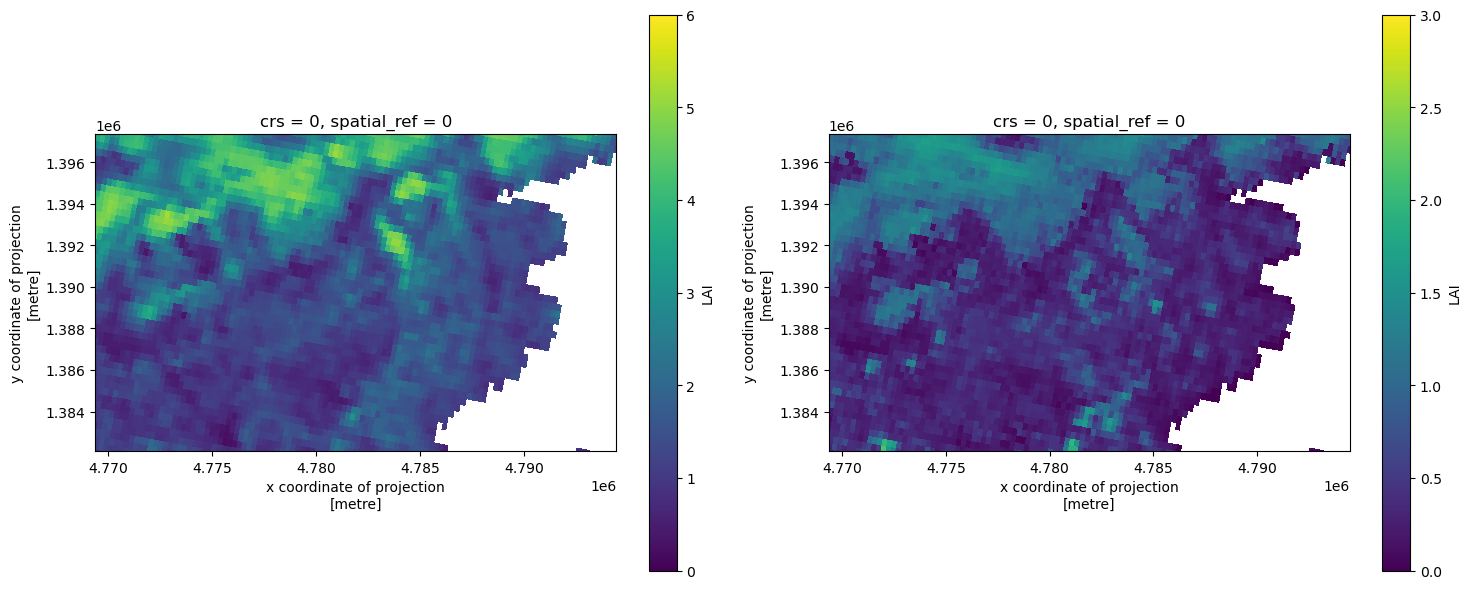

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

LAI_dc = fused_ds.LAI
LAI_mean = LAI_dc.mean("time")
LAI_std = LAI_dc.std("time")

LAI_mean.plot(ax=ax[0], vmin=0, vmax=6).axes.set_aspect('equal')
LAI_std.plot(ax=ax[1], vmin=0, vmax=3).axes.set_aspect('equal')
plt.tight_layout()

*Figure 1: Map of the mean LAI (left) and standard deviation (right) for each pixel over time around Lake Garda.*

It appears that the northern parts of our study area contain more and variable amounts of green elements per unit area. This might indicate a more complete coverage of foliage and thus forest.

## Timeseries

Now that we have detected possible forested ares, let's delve a bit deeper into the data. Remember that we deal with spatiotemporal datacube. This gives us the possibility to study changes for each time increment. Hence we can show what happens to LAI for areas marked with generally high values as well as low values. For this we will now filter the datacube with the `where` method for areas marked with and low and high mean LAI values. In turn we will aggregate the remaining datacube over the spatial dimensions to get a mean values for each time increment.

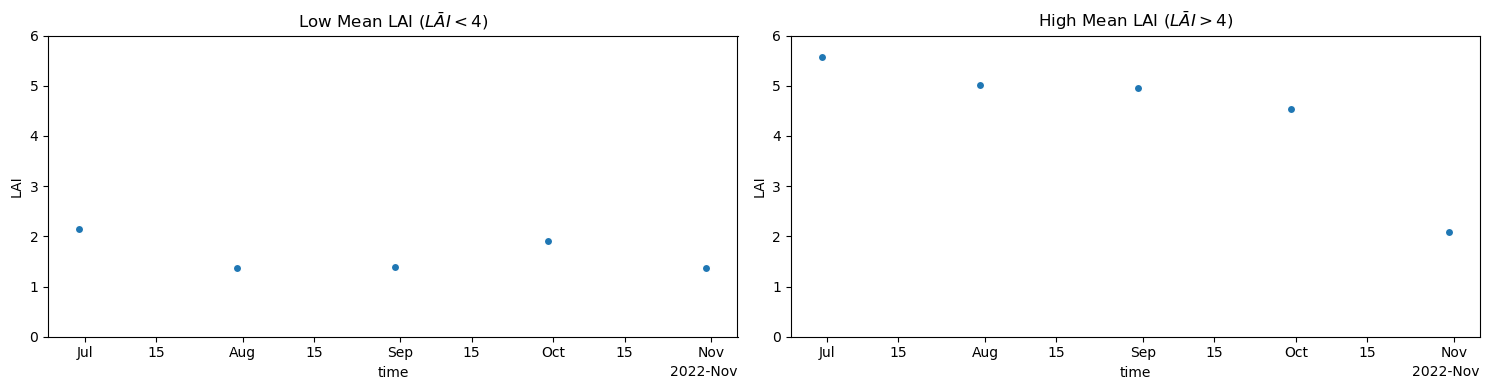

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

LAI_low = LAI_dc.where(LAI_mean < 4)
LAI_high = LAI_dc.where(LAI_mean > 4)

LAI_low.mean(["x", "y"]).plot.scatter(x="time", ax=ax[0], ylim=(0, 6))
LAI_high.mean(["x", "y"]).plot.scatter(x="time", ax=ax[1], ylim=(0, 6))
ax[0].set_title("Low Mean LAI ($\\bar{LAI} < 4$)")
ax[1].set_title("High Mean LAI ($\\bar{LAI} > 4$)")
plt.tight_layout()

*Figure 2: Timeseries of mean LAI per timeslice for areas with low (left) and high (right) mean LAI of Figure1.*

Now we can see that areas signified by high mean LAI values show a drop-off to values as low those for the other ares. Hence we might deduce that we deal deciduous forest, as can be expected for the study area around the Lake Garda in Italy.

Remember that he radar “can see” objects of about the same spatial magnitude as the radar wavelength, and larger. So, longer wavelengths like L-bands are more likely to penetrate through a forest canopy and would interact more readily with larger object like tree trunks and the forest floor. In turn, C-band microwaves are more likely to interact with spares and shrub like vegetation. The polarization of the emitted and received microwaves is on the other hand dependent on the type of backscattering with co-polarization (HH and VV) happening more frequently with direct backscatter or double bounce scattering.

Let's put this to the test by checking the microwave backscatter signatures over forested and sparsely vegetated areas as well as water bodies (Lake Garda). Let's look at the different sensor readings for the beginning of summer and autumn.

In [5]:
hv.output(widget_location='bottom')

t1 = fused_ds.gam0.\
    isel(time=2).\
    hvplot.image(robust=True, data_aspect=1, cmap="Greys_r",
                 rasterize=True, clim=(-25, 0)).\
    opts(frame_height=400, aspect="equal")

t2 = fused_ds.gam0.\
    isel(time=-1).\
    hvplot.image(robust=True, data_aspect=1, cmap="Greys_r",
                 rasterize=True, clim=(-25, 0)).\
    opts(frame_height=400, aspect="equal")

t1 + t2

BokehModel(combine_events=True, render_bundle={'docs_json': {'63668071-4c86-4df9-9ce6-553b91744c5c': {'version…

*Figure 3: (Left) Maps of Sentinel-1 and ALOS-2 $\gamma^0_E [dB]$ for the beginning of summer (left) and autumn (right).*

The most notable difference is the lower energy received for cross-polarized than for co-polarized sensors for both Sentinel-1 and ALOS-2. The latter differences are independent of the time of year. However, one can also note small changes in the received energy for the same satellite dependent on the time of year. This can be mainly discerned as changes in the contrast between north and south. These contrast differences seem to be consistent for co- and cross-polarized receiving antenna. To get a better feel for these changes over time we generate the following interactive plot. On the following plot one can select areas of a certain mean LAI (by clicking on the map) and see the associated timeseries of $\gamma^0_E for each of the sensors.

In [6]:
LAI_image = LAI_mean.hvplot.\
    image(rasterize=True, cmap='viridis', clim=(0, 6)).\
    opts(title="Mean LAI (Selectable)", frame_height=400, aspect="equal")


def get_timeseries(x, y):
    """
    Callback Function Holoviews

    Parameters
    ----------
    x: float
        numeric value for x selected on LAI map
    y: float
        numeric value for y selected on LAI map
    """

    lai_value = LAI_mean.sel(x=x, y=y, method='nearest').values

    if np.isnan(lai_value):
        select = fused_ds.where(LAI_mean.isnull())
        label = "Water"
    else:
        mask = np.isclose(LAI_mean, lai_value, atol=0.05)
        select = fused_ds.where(mask)
        label = "Mean LAI: " + str(np.round(lai_value, 1))

    time_series = select.gam0.to_dataset("sensor").\
        median(["x", "y"], skipna=True).\
        hvplot.scatter(ylim=(-30, 5)).\
        opts(title=label, frame_height=400)

    return time_series


point_stream = hv.streams.SingleTap(source=LAI_image)
time_series = hv.DynamicMap(get_timeseries, streams=[point_stream])
LAI_image + time_series

/home/nicola/Documents/work/teaching/notebooks/microwave-remote-sensing/.conda_envs/mrs-env/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1233: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,


BokehModel(combine_events=True, render_bundle={'docs_json': {'33fead7e-e3c6-4093-8495-6641ea62a9c5': {'version…

*Figure 3: (Left) Map of MEAN LAI around Lake Garda. The pixel values can be seen by hovering your mouse over the pixels. Clicking on the pixel will generate the timeseries for the associated mean LAI on the right hand-side. (Right) Timeseries of for Sentinel-1 and ALOS-2 $\gamma^0_E [dB]$.*

Can you see some patterns when analysing the different wavelengths and polarizations? Remember again that  we deal with a logarithmic scale. A measurement of 10 dB is 10 times brighter than the intensity measured at 0 dB, and 100 times brighter at 20 dB. The most notable difference is that the offset between cross polarized and co-polarised signals becomes larger at low LAI and lower at higher LAI. This might indicate the effect of volume scattering in forested areas where co- and cross-polarisation render backscattering values more equal. You will study the differences among cross and co-polarized backscattering in the homework exercise.